In [1]:
import os;
os.getcwd()

'/Users/dan/Documents/Finance/Programs/Financial Machine Learning/Backtesting'

In [2]:
import pandas as pd
from tqdm import tqdm
import sys
from datetime import datetime
# custom imports from this repo
sys.path.append("../Financial Data Structures")
from utils.read_data import read_ticks

In [3]:
ticks = "/Users/dan/Documents/Finance/Historical Data/ES-Futures-Ticks-20230807-20240806.trades.filtered.csv"
# data = read_ticks(ticks, nrows=None, date_handling="epoch")



process_date = lambda x: datetime.fromisoformat(x).timestamp()

t = 0
with open(ticks, "r") as f:
    for i, line in enumerate(f):
        if i == 1:
            line = line.strip().split(",")
            t = process_date(line[0])
            break

skipped = 0 
data = {"time": [], "price": [], "volume": [], "symbol": []}
with open(ticks, "r") as f:
    for i, line in enumerate(tqdm(f, total=82971690)):
        if i == 0:
            continue
        line = line.strip().split(",")
        time = process_date(line[0])
        if time < t:
            skipped += 1
            continue
        t += 0.25
        data["time"].append(process_date(line[0]))
        data["price"].append(float(line[1]))
        data["volume"].append(float(line[2]))
        data["symbol"].append(line[3])


82971691it [01:37, 855195.98it/s]                              


In [4]:
# #I want to sample the price every 250 ms
# subsampled = {'time': [], 'price': [], 'volume': [], 'symbol': []}
# time_ms = data['time'][0]
# skipped = 0
# for i in tqdm(range(len(data['time']))):
#     last_price = data['price'][i]
#     if data['time'][i] < time_ms:
#         skipped += 1
#         continue
#     time_ms += 0.25
#     subsampled['time'].append(time_ms)
#     subsampled['price'].append(last_price)
#     subsampled['volume'].append(data['volume'][i])
#     subsampled['symbol'].append(data['symbol'][i])

# f"{skipped=}"

In [5]:
"""
let prices be the last N=600 tick prices (sampled every 250 ms)
        # --- Strategy ---
        mu = np.mean(prices)
        std = np.std(prices)

        upper_band.append(mu + 2 * std)
        lower_band.append(mu - 2 * std)

        if app.qty == 1:
            app.current_profit = (app.last_price - app.open_price) * app.leverage - app.trade_cost
        elif app.qty == -1:
            app.current_profit = (app.open_price - app.last_price) * app.leverage - app.trade_cost

        if len(prices) == window:
            if app.qty == 0:
                if app.last_price < lower_band[-1] - app.trade_cost:
                    app.buy(contract, 1)
                    app.qty = 1
                    app.mean_side = "under"
                    print("Price is under the lower band. Buying 1 contract.")
                elif app.last_price > upper_band[-1] + app.trade_cost:
                    app.sell(contract, 1)
                    app.qty = -1
                    app.mean_side = "over"
                    print("Price is over the upper band. Selling 1 contract.")
            elif app.qty == 1:
                if app.last_price >= mu and app.mean_side == "under":
                    app.sell(contract, 1)
                    app.qty = 0
                    app.mean_side = "over"
                    print("Price is above the mean. Selling 1 contract.")
            elif app.qty == -1:
                if app.last_price <= mu and app.mean_side == "over":
                    app.buy(contract, 1)
                    app.qty = 0
                    app.mean_side = "under"
                    print("Price is below the mean. Buying 1 contract.")

"""
"""
 we are going to simulate this strategy. There is no longer an app object.

 App had these properties:
        self.mean_side = None
        self.qty = 0
        self.open_price = 0
        self.open_dir = None ("buy" or "sell")
        self.leverage = 50  # ES futures leverage
        self.commission = 2.25  # ES commission per contract
        self.trade_cost = self.commission * 2 / self.leverage

        self.current_profit = 0
        self.total_profit = 0

we will need to track these properties in the simulation
 we assume 1 tick of slippage against us on each trade
"""

from collections import deque
import numpy as np

window = 600
prices = deque(maxlen=window)
upper_band = 0
lower_band = 0
mu = 0
std = 0
qty = 0
open_price = 0
current_profit = 0
total_profit = 0
commission = 2.25
leverage = 50
trade_cost = commission * 2 / leverage


buys = []
sells = []
holding_periods = []

for i in tqdm(range(len(data['time']))):
    last_price = data['price'][i]
    prices.append(last_price)
    if len(prices) < window:
        continue

    mu = np.mean(prices)
    std = np.std(prices)

    upper_band = mu + 2 * std
    lower_band = mu - 2 * std

    if qty == 1:
        current_profit = (last_price - open_price) * leverage - trade_cost
    elif qty == -1:
        current_profit = (open_price - last_price) * leverage - trade_cost

    if qty == 0: 
        if last_price < lower_band - trade_cost:
            open_price = last_price
            qty = 1
            mean_side = "under"
            buys.append(i)

        elif last_price > upper_band + trade_cost:
            open_price = last_price
            qty = -1
            mean_side = "over"
            sells.append(i)

    elif qty == 1:
        if last_price >= mu and mean_side == "under":
            open_price = last_price
            qty = 0
            mean_side = "over"
            total_profit += current_profit
            sells.append(i)
            holding_periods.append(sells[-1] - buys[-1])

    elif qty == -1:
        if last_price <= mu and mean_side == "over":
            open_price = last_price
            qty = 0
            mean_side = "under"
            total_profit += current_profit
            buys.append(i)
            holding_periods.append(buys[-1] - sells[-1])


f"{total_profit=}\n{np.mean(holding_periods)=}"




 82%|████████▏ | 67175479/82181655 [53:36<11:17, 22135.11it/s]  

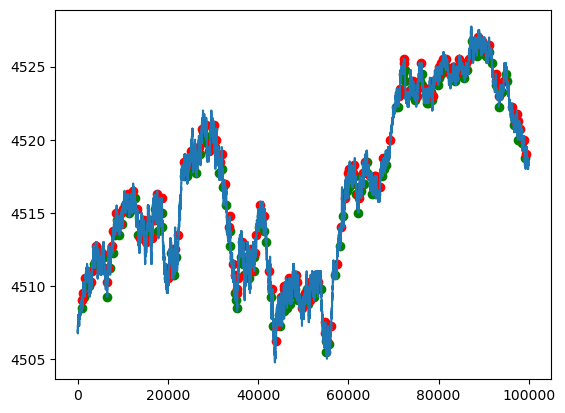

In [ ]:
# plot the prices with markers for buys and sells
import matplotlib.pyplot as plt
plt.plot(subsampled['price'])
plt.scatter(buys, [subsampled['price'][i] for i in buys], color='green', marker='triangle_up')
plt.scatter(sells, [subsampled['price'][i] for i in sells], color='red', marker='triangle_down')
plt.show()